# Teste A/B Propaganda

Dataset contendo um teste A/B feio por uma agência de propaganda.

Fonte: https://www.kaggle.com/datasets/osuolaleemmanuel/ad-ab-testing

Neste projeto serão feitas análises com Teste A/B sobre o rendimento de uma alteração em um anúncio interativo fictício, com uma pergunta e dois botões: Sim e Não.

Fiz algumas alterações conceituais em relação ao que é explicado na página do dataset no Kaggle.

#### Dicionário

**auction_id:** identificação do usuário que teve contato com pelo menos um dos anúncios. Os usuários que optaram por não responder têm as colunas 'yes' e 'no' com valor 0.

**experiment:** grupo do usuário, controle ou experimental.
  * **control:** usuários que viram um anúncio antigo.
  * **exposed:** usuários que viram o anúncio novo, que está sendo avaliado.

**date:** data em que o usuário teve contato com o experimento (no formato YYYY-MM-DD).

**hour:** hora do dia (no formato HH)

**device_make:** tipo de aparelho do usuário.

**platform_os:** id do sistema operacional do usuário.

**browser:** nome do navegador que o usuário utilizou para ver o questionário.

**yes:** 1 se o usuário pressionou o botão YES do questionário.

**no:** 1 se o usuário pressionou o botão NO do questionário.

* Neste contexto, a conversão do anúncio será medida pelo usuários que optaram pelo YES, podem ser vistos como pessoas que viram o anúncio e adquiriram o produto, ou acharam a informação do banner relevante.

Referências

* AB Testing :Control versus experimental (binary data) using Python and Scipy
  * https://www.youtube.com/watch?v=GnCQYgEfzPI&t=1s&ab_channel=FunChannel_byMaddy

* How to run A/B Tests as a Data Scientist!
  * https://www.youtube.com/watch?v=OVgi6ftJiyQ&ab_channel=CodeEmporium


### Imports

In [1]:
!pip install matplotlib==3.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from scipy.stats import chi2_contingency
from scipy.stats import chi

# Abertura do dataset

In [3]:
# Tutorial: https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/

!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/osuolaleemmanuel/ad-ab-testing")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tassianaoliveira
Your Kaggle Key: ··········


100%|██████████| 216k/216k [00:00<00:00, 30.4MB/s]

In [4]:
data = pd.read_csv('/content/ad-ab-testing/AdSmartABdata - AdSmartABdata.csv')
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


# Tratamentos

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


* Não há dados nulos.
* A data pode ser convertida para datetime.

In [6]:
data.iloc[: ,0].nunique() == data.shape[0]

True

* Não há linhas duplicadas no dataset.

In [7]:
n_auction_ids = len(data['auction_id'].unique())
print(f'Linhas do dataset = {data.shape[0]}')
print(f'Quantidade de usuários = {n_auction_ids}')

Linhas do dataset = 8077
Quantidade de usuários = 8077


* Não há participações repetidas de um mesmo usuário.

In [8]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   auction_id   8077 non-null   object        
 1   experiment   8077 non-null   object        
 2   date         8077 non-null   datetime64[ns]
 3   hour         8077 non-null   int64         
 4   device_make  8077 non-null   object        
 5   platform_os  8077 non-null   int64         
 6   browser      8077 non-null   object        
 7   yes          8077 non-null   int64         
 8   no           8077 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 568.0+ KB


# Resumo de números do teste

## Verificação da proporção de cada grupo

In [9]:
experiment_count = data.groupby('experiment').count().reset_index()[['experiment', 'auction_id']]
experiment_count.rename(columns = {'auction_id':'n_users'}, inplace = True)

total_usuarios = experiment_count['n_users'].sum()
print(f'O total de usuários que viram os anúncios foi de {total_usuarios}.')

experiment_count['%_do_total'] = (experiment_count['n_users'] / total_usuarios * 100).round(2)

experiment_count

O total de usuários que viram os anúncios foi de 8077.


,experiment,n_users,%_do_total
0,control,4071,50.4
1,exposed,4006,49.6


* A proporção de usuários exposta em cada grupo do experimento foi próxima à 50%.

## Botões pressionados em cada grupo

In [10]:
data['button'] = ['None' for x in data['auction_id']]
data.loc[data['yes'] == 1, 'button'] = 'Yes'
data.loc[data['no'] == 1, 'button'] = 'No'
#data.tail(15)

In [11]:
experiment_button = data.groupby(['experiment', 'button']).count()
experiment_button = experiment_button.reset_index()[['experiment', 'button', 'auction_id']]
experiment_button.rename(columns = {'auction_id': 'n_users'}, inplace = True)
experiment_button

,experiment,button,n_users
0,control,No,322
1,control,None,3485
2,control,Yes,264
3,exposed,No,349
4,exposed,None,3349
5,exposed,Yes,308


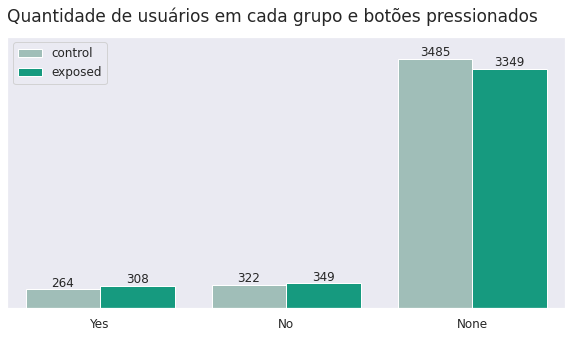

In [34]:
plt.figure(figsize = (10,5))
palette = ['#9bc3bb', '#00b08c']

ax = sns.barplot(data = experiment_button, x = 'button', y = 'n_users', hue = 'experiment', palette = palette, order = ['Yes', 'No', 'None'])

ax.set_title('Quantidade de usuários em cada grupo e botões pressionados', fontsize = 17, pad = 15, horizontalalignment = 'left', x = 0)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.set_ylabel('')
ax.set_xlabel('')
plt.xticks(fontsize = 12)
plt.yticks([])

plt.legend(title='', fontsize = 12)

ax.set_ylim((0, 3800))

plt.show()

* Em números totais, o grupo exposto ao novo anúncio interagiu mais do que os usuários do grupo de controle.

* Entretanto, a diferença é pequena e pode não ser estatisticamente relevante.

## Duração do experimento

In [13]:
start_time = data['date'].min()
end_time = data['date'].max()
duration = end_time - start_time

print(f'Começo do experimento: {start_time}')
print(f'Fim do experimento: {end_time}\n')
print(f'Duração do experimento: {duration.days} dias.')

Começo do experimento: 2020-07-03 00:00:00
Fim do experimento: 2020-07-10 00:00:00

Duração do experimento: 7 dias.


# Análise por grupo

In [14]:
interactions = data.query('(yes == 1) or (no == 1)')

control = interactions.query('experiment == "control"')
exposed = interactions.query('experiment == "exposed"')

n_interactions_control = control.shape[0]
n_interactions_exposed = exposed.shape[0]
n_interactions = interactions.shape[0]

print(f'Dos {n_interactions} usuários que interagiram com os anúncios, {n_interactions_control} viram o anúncio antigo.')
print(f'Dos {n_interactions} usuários que interagiram com os anúncios, {n_interactions_exposed} viram o anúncio novo.')

Dos 1243 usuários que interagiram com os anúncios, 586 viram o anúncio antigo.
Dos 1243 usuários que interagiram com os anúncios, 657 viram o anúncio novo.


In [15]:
control_percentuals = control.groupby('button').count().reset_index()[['button', 'auction_id']]
control_percentuals['%'] = (control_percentuals['auction_id'] / control.shape[0] * 100).round(2)
control_percentuals.rename(columns = {'auction_id':'n_users'}, inplace = True)
control_percentuals

,button,n_users,%
0,No,322,54.95
1,Yes,264,45.05


* A quantidade de usuários que escolheram "Yes" no anúncio **antigo** foi de 264.

In [16]:
exposed_percentuals = exposed.groupby('button').count().reset_index()[['button', 'auction_id']]
exposed_percentuals['%'] = (exposed_percentuals['auction_id'] / exposed.shape[0] * 100).round(2)
exposed_percentuals.rename(columns = {'auction_id':'n_users'}, inplace = True)
exposed_percentuals

,button,n_users,%
0,No,349,53.12
1,Yes,308,46.88


* A quantidade de usuários que escolheram "Yes" no anúncio **novo** foi de 308.

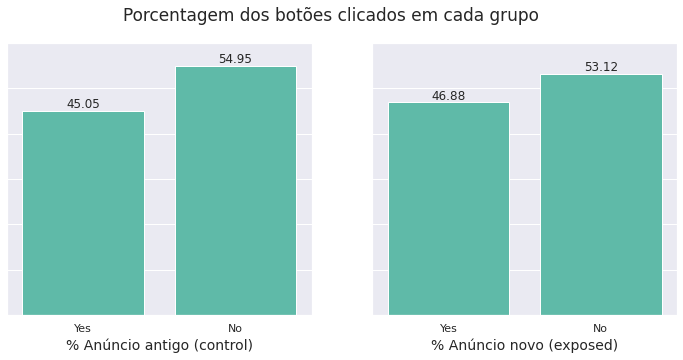

In [40]:
sns.set_theme(style="darkgrid")
palette = ['#50c9b1' for i in range(2)]

fig, axs = plt.subplots(1, 2, sharey=True, figsize = (12,5))
fig.suptitle('Porcentagem dos botões clicados em cada grupo', 
             fontsize = 17)

ax0 = sns.barplot(ax = axs[0], data = control_percentuals, x = 'button', y = '%',
                  palette = palette, order = ['Yes', 'No'])
ax0.bar_label(ax0.containers[0])
ax0.set_xlabel('% Anúncio antigo (control)', fontsize = 14)
ax0.set_ylabel('')
ax0.set(yticklabels = [])

ax1 = sns.barplot(ax = axs[1], data = exposed_percentuals, x = 'button', y = '%',
                  palette = palette, order = ['Yes', 'No'])
ax1.bar_label(ax1.containers[0])
ax1.set_xlabel('% Anúncio novo (exposed)', fontsize = 14)
ax1.set_ylabel('')
ax1.set(yticklabels = [])

ax1.set_ylim((0, 60))

plt.show()

* A diferença de porcentagens de usuários que clicaram em "Yes" nos dois anúncios foi de, aproximadamente, 1,83%.

* O teste a seguir irá avaliar se essa diferença é estatisticamente relevante ou não.

# Análise por dia

## Quantidade de usuários convertidos por dia de experimento em cada grupo

In [25]:
data['day'] = data['date'].apply(lambda x: (x - start_time).days)
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no,button,day
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0,None,7
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0,None,4
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1,No,2
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0,None,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0,None,0


In [26]:
interactions_per_day = data.groupby(['day', 'experiment']).sum()[['yes', 'no']].reset_index()
interactions_per_day

,day,experiment,yes,no
0,0,control,104,129
1,0,exposed,43,49
2,1,control,30,38
3,1,exposed,46,45
4,2,control,17,26
5,2,exposed,35,39
6,3,control,12,14
7,3,exposed,23,25
8,4,control,16,21
9,4,exposed,22,24


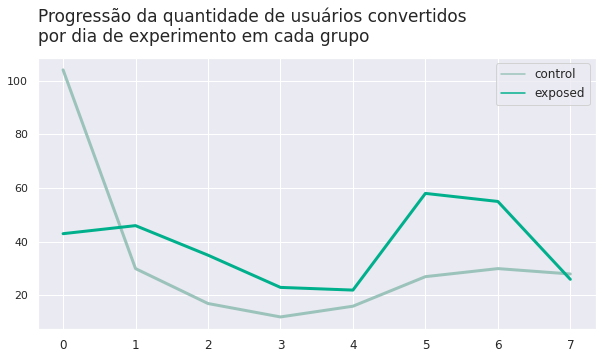

In [27]:
sns.set_theme(style="darkgrid")
plt.figure(figsize = (10,5))
palette = ['#9bc3bb', '#00b08c']

ax = sns.lineplot(data = interactions_per_day, x = 'day', y = 'yes', hue = 'experiment', palette = palette, lw = 3)

ax.set_title('Progressão da quantidade de usuários convertidos\npor dia de experimento em cada grupo', fontsize = 17, pad = 15, horizontalalignment = 'left', x = 0)
ax.set_ylabel('')
ax.set_xlabel('')
plt.xticks(fontsize = 12)

plt.legend(title='', fontsize = 12)

plt.show()

* No dia 0, a quantidade de usuários que escolheram o YES (convertidos) no grupo de controle foi muito maior do que no grupo experimental.

* Em seguida, os números foram mais promissores para o grupo experimental.

* No dia 7, último dia do experimento, as quantidades convergiram.

## Quantidade de usuários que interagiram com o anúncio por dia de experimento em cada grupo

In [28]:
interactions_per_day['n_users'] = interactions_per_day['yes'] + interactions_per_day['no']
interactions_per_day

,day,experiment,yes,no,n_users
0,0,control,104,129,233
1,0,exposed,43,49,92
2,1,control,30,38,68
3,1,exposed,46,45,91
4,2,control,17,26,43
5,2,exposed,35,39,74
6,3,control,12,14,26
7,3,exposed,23,25,48
8,4,control,16,21,37
9,4,exposed,22,24,46


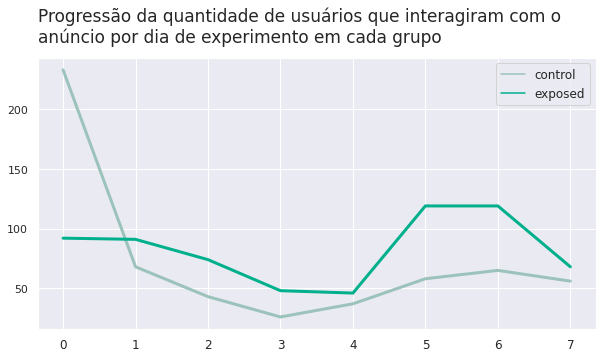

In [31]:
sns.set_theme(style="darkgrid")
plt.figure(figsize = (10,5))
palette = ['#9bc3bb', '#00b08c']

ax = sns.lineplot(data = interactions_per_day, x = 'day', y = 'n_users', hue = 'experiment', palette = palette, lw = 3)

ax.set_title('Progressão da quantidade de usuários que interagiram com o\nanúncio por dia de experimento em cada grupo', fontsize = 17, pad = 15, horizontalalignment = 'left', x = 0)
ax.set_ylabel('')
ax.set_xlabel('')
plt.xticks(fontsize = 12)

plt.legend(title='', fontsize = 12)

plt.show()

* As curvas com as quantidades totais de interações por dia e as curvas com quantidade de usuários convertidos têm comportamentos semelhantes.

## Taxa de conversão por grupo em cada dia do experimento

In [32]:
interactions_per_day['conversion'] = (interactions_per_day['yes'] * 100) / (interactions_per_day['n_users'])
interactions_per_day

,day,experiment,yes,no,n_users,conversion
0,0,control,104,129,233,44.635193
1,0,exposed,43,49,92,46.739130
2,1,control,30,38,68,44.117647
3,1,exposed,46,45,91,50.549451
4,2,control,17,26,43,39.534884
5,2,exposed,35,39,74,47.297297
6,3,control,12,14,26,46.153846
7,3,exposed,23,25,48,47.916667
8,4,control,16,21,37,43.243243
9,4,exposed,22,24,46,47.826087


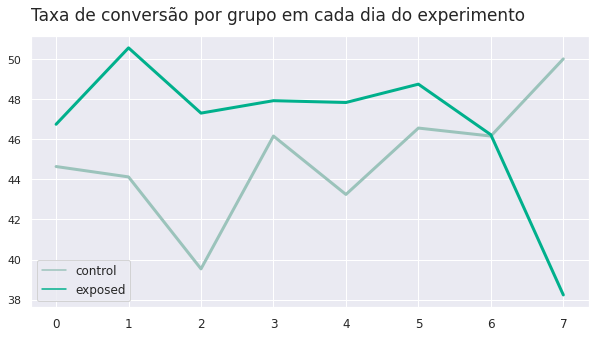

In [33]:
sns.set_theme(style="darkgrid")
plt.figure(figsize = (10,5))
palette = ['#9bc3bb', '#00b08c']

ax = sns.lineplot(data = interactions_per_day, x = 'day', y = 'conversion', hue = 'experiment', palette = palette, lw = 3)

ax.set_title('Taxa de conversão por grupo em cada dia do experimento', fontsize = 17, pad = 15, horizontalalignment = 'left', x = 0)
ax.set_ylabel('')
ax.set_xlabel('')
plt.xticks(fontsize = 12)

plt.legend(title='', fontsize = 12)

plt.show()

* Ao obervar a taxa de conversão, o grupo experimental teve um rendimento melhor do que o controle até o quinto dia.

* No sexto dia as taxas foram semelhantes.

* No sétimo dia, o grupo experimental teve uma taxa de conversão muito mais baixa que o grupo de controle, entretanto

## Conclusões

* Apesar de, em número absolutos, o anúncio novo ter convertido mais usuários do que o anúncio antigo neste período de 7 dias, a sua taxa de conversão caiu no últimos 2 dias.

* Em uma situação real, seria interessante analisar o contexto do que foi alterado no anúncio. Para uma queda tão rápida, pode envolver um meme que ficou saturado, uma imagem que remete a algo que tomou repersursão repentina (timing), ou simplesmente atinge um público seleto que se esgotou.

* Dependendo do contexto, também seria interessante manter o experimento por mais tempo.

# Formulação das hipóteses

A Hipótese Nula afirma que as quantidades de pessoas que escolheram "Yes" nos dois anúncios foram estatisticamente iguais, enquanto a Hipótese Alternativa afirma o contrário.

> $H_0: Y_n - Y_a = 0$

> $H_1: Y_n - Y_a \ne 0$ 

* O nível de significância do Teste A/B será de 5%. 

* Como, em valores absolutos, a quantidade de pessoas que escolheram "Yes" no anúncio novo é maior do que no anúncio antigo, a rejeição de $H_0$ e aceitação de $H_1$ também afirma a superioridade ($Yn > Ya$).

# Teste Qui-Quadrado ($\chi^2$)

In [85]:
contigency_table = control_percentuals[['button', 'n_users']].copy()
contigency_table.rename(columns = {'n_users':'control'}, inplace = True)
contigency_table['exposed'] = exposed_percentuals['n_users']

contigency_table.loc[contigency_table['button'] == 'No', 'button'] = 0
contigency_table.loc[contigency_table['button'] == 'Yes', 'button'] = 1

contigency_table.set_index('button', inplace = True)

contigency_table

,control,exposed
button,,
0,322,349
1,264,308


In [87]:
chi_2, p_value, df, _ = chi2_contingency(contigency_table, correction=False)
print(f'X² = {chi_2}')
print(f'p-value = {p_value}')
print(f'degrees of freedom = {df}')

X² = 0.41690289642162887
p-value = 0.518486498219898
degrees of freedom = 1


## Teste com p-valor

* $\alpha = 0.05$ (5%)

In [90]:
alpha = 0.05

if p_value <= alpha:
  print('Rejeitar Hipótese Nula.')
else:
  print('Aceitar Hipótese Nula.')

Aceitar Hipótese Nula.


* A quantidade de usuários que 

## Teste com valor crítico

In [91]:
chi_2_alpha = chi.ppf(1 - alpha, df) ** 2
chi_2_alpha

3.8414588206941245

In [92]:
if chi_2 > chi_2_alpha:
  print('Rejeitar Hipótese Nula.')
else:
  print('Aceitar Hipótese Nula.')

Aceitar Hipótese Nula.


## Conclusões

* A Hipótese Nula pode ser aceita, ou seja, não há diferença estatisticamente relevante entre as conversões de usuários (que escolheram o YES) dos dois anúncios.

# Conclusões

* Considerando a conclusão do Teste $\chi^2$, não há diferença entre manter ou não o anúncio novo.

* Entretanto, observando-se as taxas de conversão, talvez o anúncio novo apenas não tenha sido avaliado em uma boa hora e o problema não esteja na alteração em si, e sim no contexto dos usuários.

* Caso não seja possível avaliar os dois anúncios por mais uma semana, creio que a melhor opção seja tirar a circulação o novo anúncio.